<a href="https://colab.research.google.com/github/robgon-art/ai-memer/blob/main/AI_Memer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![AI-memer Output](https://raw.githubusercontent.com/robgon-art/ai-memer/main/images/AI-Memer%20Cover%202.jpg)
# AI-Memer: Using Machine Learning to Create Funny Memes 
### How to create new memes using images from Wikimedia Commons and OpenImages with captions generated automatically by GPT-3 and GPT-Neo
By Robert. A Gonsalves

You can read my article about this project on Medium.

The source code and generated memes are released under the CC BY-SA license.

![CC BY-NC-SA](https://licensebuttons.net/l/by-sa/4.0/88x31.png)

# **Initalize the System**
Hit the Run Cell (play) button to intialize the system. Note that it takes about ten minutes to set up all the components.

In [ ]:
#@title
!wget https://raw.githubusercontent.com/openimages/dataset/master/downloader.py
!pip install boto3 > /dev/null 2>&1
!gdown --id 1TS5K0BGk5ruCF-bc6yeMSAEb5z8Oi_st
!gdown --id 1-2ForMsp58l6DVAeUqEvW0N24-YITf5o

import numpy as np
text_features16 = np.load("ai-memer_embeddings16.npy")
print(text_features16.shape)
import pickle
annotations = pickle.load(open("ai-memer_annotations.pkl", "rb"))
print(annotations[520000])

!pip install wikipedia

import requests
import shutil
import os

def download_file(url, path):
  filename = url.split("/")[-1]
  file_path = os.path.join(path, filename)
  r = requests.get(url, stream=True)
  if r.status_code == 200:
    r.raw.decode_content = True
    with open(file_path,'wb') as f:
      shutil.copyfileobj(r.raw, f)

def get_first_words(text, num):
  parts = text.split()
  result = ""
  for p in parts[:num]:
    result += p + " "
  return result.strip()

import requests
import re
from bs4 import BeautifulSoup
def get_file_info(filename):
  url = "https://magnus-toolserver.toolforge.org/commonsapi.php?image=" + filename
  page = requests.get(url)
  soup = BeautifulSoup(page.text, 'html.parser')

  author_info = soup.find("author")
  if author_info is None:
    author = "N/A"
  else:
    author = author_info.get_text()
    author = BeautifulSoup(author, 'html.parser').get_text()
  author = get_first_words(author, 3)

  license_info = soup.find("license")
  if license_info is None:
    license = "Fair Use"
  else:
    license = license_info.get_text()
    license = BeautifulSoup(license, 'html.parser').get_text()
  license = get_first_words(license, 3)

  r = soup.find("response")
  desc = r.find("description", recursive=False)
  description = BeautifulSoup(desc.get_text(), 'html.parser').get_text()
  description = description.replace("\n", " ").strip()
  if "English:" in description:
    start = description.find("English:")
    description = description[start+8:].strip()
    if ":" in description:
      stop = description.find(":")
      while len(description) > 0 and description[stop] is not " ":
        stop -=1
      description = description[0:stop].strip()
  description = get_first_words(description, 30)
  if len(description) == 0:
    filename = url[61:]
    description = filename[:-4].replace("_", " ")

  return author, license, description

import wikipedia

!wget https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt -O model.pt
import torch
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()
!wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz
from functools import lru_cache
@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))
def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs
def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()
def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text
class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)
    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)
        if not pairs:
            return token+'</w>'
        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word
    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens
    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text
  
!pip install openai
!pip install ftfy

import ftfy
import gzip
import regex as re
import html
tokenizer = SimpleTokenizer()
def get_text_features(sentence):
  encoded_sentence = tokenizer.encode(sentence)
  # print(len(encoded_sentence), len(sentence))
  text_tokens = [encoded_sentence[:model.context_length]]
  text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
  for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)
  text_input = text_input.cuda()
  with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
  return text_features

def get_top_N_semantic_similarity(similarity_list, N):
  results = zip(range(len(similarity_list)), similarity_list)
  results = sorted(results, key=lambda x: x[1],reverse = True)
  scores = []
  indices = []
  for index,score in results[:N]:
    scores.append(score)
    indices.append(index)
  return scores, indices

!mkdir open_images
!mkdir wiki_images

!wget https://github.com/lipsumar/meme-caption/raw/master/impact.ttf


def drawTextWithOutline(text, x, y):
    draw.text((x-2, y-2), text,(0,0,0),font=font)
    draw.text((x+2, y-2), text,(0,0,0),font=font)
    draw.text((x+2, y+2), text,(0,0,0),font=font)
    draw.text((x-2, y+2), text,(0,0,0),font=font)
    draw.text((x, y), text, (255,255,255), font=font)
    return

def drawText(text, pos):
    text = text.upper()
    w, h = draw.textsize(text, font) # measure the size the text will take

    lineCount = 1
    if w > img.width:
        lineCount = int(round((w / img.width) + 1))

    lines = []
    if lineCount > 1:

        lastCut = 0
        isLast = False
        for i in range(0,lineCount):
            if lastCut == 0:
                cut = int((len(text) / lineCount) * i + 0.5)
            else:
                cut = lastCut

            if i < lineCount-1:
                nextCut = int((len(text) / lineCount) * (i+1) + 0.5)
            else:
                nextCut = len(text)
                isLast = True

            # make sure we don't cut words in half
            if not (nextCut == len(text) or text[nextCut] == " "):
                while text[nextCut] != " ":
                    nextCut += 1

            line = text[cut:nextCut].strip()

            # is line still fitting ?
            w, h = draw.textsize(line, font)
            if not isLast and w > img.width:
                nextCut -= 1
                while text[nextCut] != " ":
                    nextCut -= 1

            lastCut = nextCut
            lines.append(text[cut:nextCut].strip())
    else:
        lines.append(text)

    lastY = -h
    if pos == "bottom":
        lastY = img.height - h * (lineCount+1) - 10

    for i in range(0, lineCount):
        w, h = draw.textsize(lines[i], font)
        x = img.width/2 - w/2
        y = lastY + h
        drawTextWithOutline(lines[i], x, y)
        lastY = y

def display_image_in_actual_size(im_path, dpi):
  im_data = plt.imread(im_path)
  height, width, depth = im_data.shape
  figsize = width / float(dpi), height / float(dpi)
  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])
  ax.axis('off')
  ax.imshow(im_data)
  plt.show()

import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFont, ImageDraw

!pip install transformers
from transformers import pipeline, AutoTokenizer
generator = pipeline('text-generation', device=0, model='EleutherAI/gpt-neo-2.7B')
import openai
openai.api_key = "your api key"
def cleanup_caption(caption):
  caption = caption.strip().replace('"', '')
  parts = caption.split()
  caption = " ".join(parts).strip()
  if caption.endswith("."):
    caption = caption[:-1]
  caption = caption.upper()
  return caption

gpt_neo_tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt_neo_prompt = """Create a funny caption for a meme. 

Theme: disaster girl
Image description: A picture of a girl looking at us as her house burns down
Caption: There was a spider. It's gone now.

Theme: grumpy cat
Image description: A face of a cat who looks unhappy
Caption: I don't like Mondays

"""

def get_warning_level(content_to_classify):
  content_filter_results = openai.Completion.create(
        engine="content-filter-alpha-c4",
        prompt = "<|endoftext|>"+content_to_classify+"\n--\nLabel:",
        temperature=0,
        max_tokens=1,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        logprobs=10)
  output_label = content_filter_results["choices"][0]["text"]
  # This is the probability at which we evaluate that a "2" is likely real
  # vs. should be discarded as a false positive
  toxic_threshold = -0.355
  if output_label == "2":
    # If the model returns "2", return its confidence in 2 or other output-labels
    logprobs = content_filter_results["choices"][0]["logprobs"]["top_logprobs"][0]
    # If the model is not sufficiently confident in "2",
    # choose the most probable of "0" or "1"
    # Guaranteed to have a confidence for 2 since this was the selected token.
    if logprobs["2"] < toxic_threshold:
      logprob_0 = logprobs.get("0", None)
      logprob_1 = logprobs.get("1", None)
      # If both "0" and "1" have probabilities, set the output label
      # to whichever is most probable
      if logprob_0 is not None and logprob_1 is not None:
        if logprob_0 >= logprob_1:
          output_label = "0"
        else:
          output_label = "1"
      # If only one of them is found, set output label to that one
      elif logprob_0 is not None:
        output_label = "0"
      elif logprob_1 is not None:
        output_label = "1"
      # If neither "0" or "1" are available, stick with "2"
      # by leaving output_label unchanged.
  # if the most probable token is none of "0", "1", or "2"
  # this should be set as unsafe
  if output_label not in ["0", "1", "2"]:
    output_label = "2"
  return output_label

# **Search for Background Images**
Enter a topic then hit the Run Cell button search and download related images from OpenImages and Wikipedia.

['Dog', 'United States presidential pets', 'Pet']
Dog
United States presidential pets
Pet


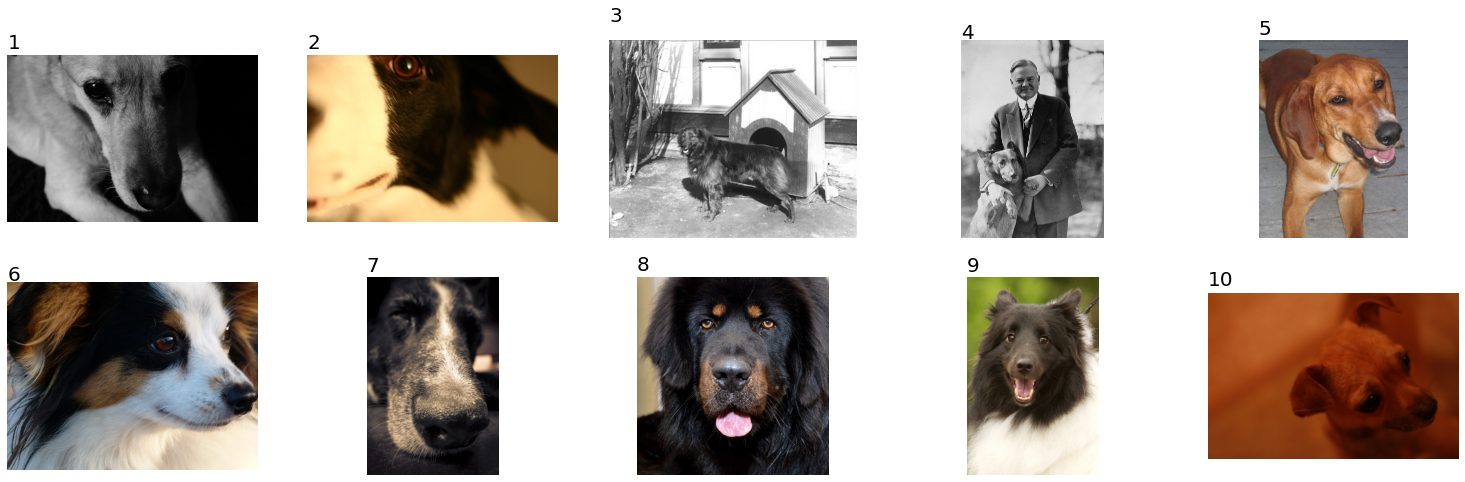

In [25]:
find_image = "pet dog" #@param {type:"string"}
import warnings
warnings.filterwarnings('ignore')
text_query = find_image
feature_text = "<|startoftext|> Image of a " + text_query + " <|endoftext|>"
query_features = get_text_features(feature_text)
text_similarity = query_features.cpu().numpy() @ text_features16.T
text_similarity = text_similarity[0]

text_scores, text_indices = get_top_N_semantic_similarity(text_similarity, N=20)

f = open("images.txt", "w")
for i in text_indices:
  f.write(annotations[i][0] +"\n")
f.close()

# get the images from OpenImages
print("Downloading images from OpenImages")
!python downloader.py images.txt --download_folder=open_images --num_processes=1

all_images = []
all_image_metadata = []
all_files = []
for i in range(0, 20):
  image_id = annotations[text_indices[i]][0]
  description = annotations[text_indices[i]][1]
  author = annotations[text_indices[i]][2]
  parts = image_id.split("/")
  file_path = "open_images/" + parts[1] + ".jpg"
  if file_path not in all_files:
    metadata = ("OpenImages", file_path, description, author, "CC BY 2.0")
    all_image_metadata.append(metadata)
    img = Image.open(file_path)
    img = img.convert(mode="RGB")
    all_images.append(img)
    all_files.append(file_path)

# get the images Wikipedia
print("Downloading images from Wikipedia")
results = wikipedia.search(text_query, results=3)
print(results)
for r in results:
  print(r)
  try:
    p = wikipedia.page(r)
  except:
    continue
  try:
    for pi in p.images[:10]:
      if pi.endswith(".jpg"):
        filename = pi.split("/")[-1]
        if "wikipedia/commons" in pi:
          source = "Wikipedia Commons"
          author, license, description = get_file_info(filename)
        else:
          source = "Wikipedia"
          author = "N/A"
          license = "Fair Use"
          description = filename[:-4].replace("_", " ")
        download_file(pi, "wiki_images")
        file_path = "wiki_images/" + filename
        if file_path not in all_files:
          metadata = (source, file_path, description, author, license)
          all_image_metadata.append(metadata)
          img = Image.open(file_path)
          img = img.convert(mode="RGB")
          all_images.append(img)
          all_files.append(file_path)
  except:
    continue

from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, InterpolationMode
input_resolution = model.input_resolution.item()
image_features = torch.empty((0, 512))

preprocess = Compose([
    Resize(input_resolution, interpolation=InterpolationMode.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()
images = [preprocess(im) for im in all_images]
image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]
with torch.no_grad():
  image_features = model.encode_image(image_input).float().cpu()  
image_features /= image_features.norm(dim=-1, keepdim=True)

image_similarity = query_features.cpu().numpy() @ image_features.numpy().T
image_similarity = image_similarity[0]
image_scores, image_indices = get_top_N_semantic_similarity(image_similarity, N=10)

fig=plt.figure(figsize=(26, 8))
columns = 5
rows = 2
for i in range(1, columns*rows + 1):
  file_name = all_image_metadata[image_indices[i-1]][1]
  img = Image.open(file_name)
  img = img.convert(mode="RGB")
  fig.add_subplot(rows, columns, i)
  plt.margins(y=10)
  plt.imshow(img)
  plt.text(0, -30, str(i), fontsize=20)
  plt.axis("off")
plt.show()

# **Specify Open.AI API Key (Optional)**

If you have an OpenAI account, you can use their **GPT-3 davici** model to generate captions by entering your API Key and running the following cell. Note that this will cost about $0.03 per run.

Otherwise you can use **Eleuther GPT-Neo** for free.

In [3]:
openai.api_key = "your api key"

# **Generate Captions**
Choose an image then hit the Run Cell button to generate captions for this meme.

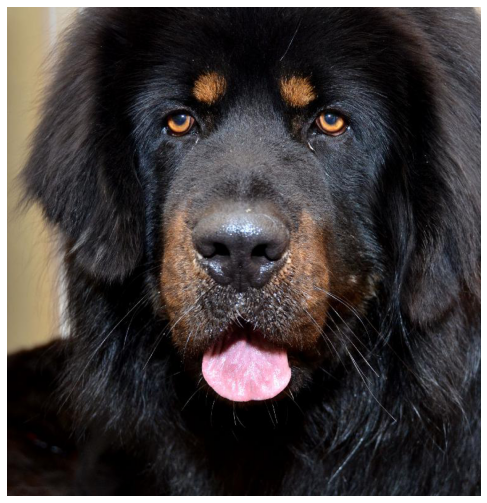

Captions:
 1: I AM A DOG
 2: I LOVE PET DOGS
 3: I'M NOT A DOG PERSON
 4: I'M A DOG
 5: I LOVE MY DOG
 6: I LOVE DOGS
 7: I LIKE MY DOG
 8: I AM A DOG
 9: I HATE MONDAYS
10: THIS IS DOG


In [27]:
choose_image = 8 #@param {type:"slider", min:1, max:10, step:1}
fig=plt.figure(figsize=(9, 9))
file_name = all_image_metadata[image_indices[choose_image-1]][1]
img = Image.open(file_name)
img = img.convert(mode="RGB")
plt.imshow(img)
plt.axis("off")
plt.show()
annotation = all_image_metadata[image_indices[choose_image-1]][2]
captions = []
print("Captions:")
if (openai.api_key == "your api key"):
  ai_engine = "EleutherAI GPT-Neo"
  prompt = gpt_neo_prompt + "Theme: " + text_query + "\nDescription: " + annotation
  prompt += "\nCaption:"
  for i in range(10):
    results = generator(prompt, do_sample=True, min_length=100, max_length=150, 
      temperature=0.7, top_p=1.0, pad_token_id=gpt_neo_tokenizer.eos_token_id)
    caption = results[0]["generated_text"]
    caption = caption[len(prompt):].strip()
    caption = caption[:caption.find("\n")]
    caption = cleanup_caption(caption)
    captions.append(caption)
    print(f'{i+1:>2}'+":", caption)
else:
  ai_engine = "OpenAI GPT-3"
  prompt = "Create a funny caption for a new meme about " + text_query + ". The background picture is " + annotation + ".\n"
  for i in range(10):
    response = openai.Completion.create(
      engine="davinci-instruct-beta",
      prompt=prompt,
      temperature=0.7,
      max_tokens=64,
      top_p=0.5,
      frequency_penalty=0.5,
      presence_penalty=0.5,
      best_of=1
    )
    caption = response["choices"][0]["text"]
    warning_level = get_warning_level(caption)
    caption = cleanup_caption(caption)
    captions.append(caption)
    warning = ""
    if warning_level == "1":
      warning = "  (Warning Level 1: Sensitive Text)"
    elif warning_level == "2":
      warning = "  (Warning Level 2: Unsafe Text)"
    print(f'{i+1:>2}'+":", caption, warning)

# **Format the Caption**
Choose the caption and formatting options then hit the Run Cell button to generate the meme.

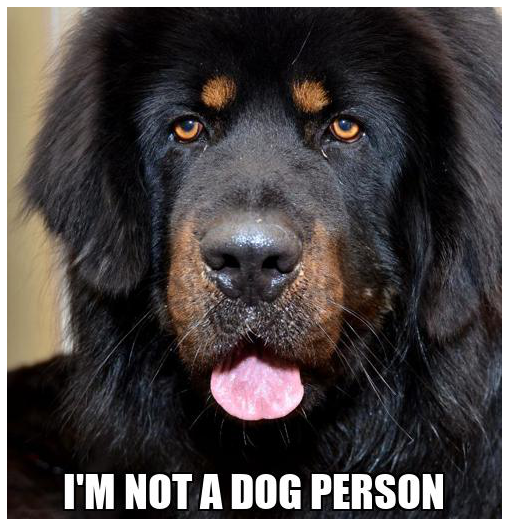

Meme by AI-Memer, Image by Irita Kirsbluma, Caption by EleutherAI GPT-Neo, License: CC BY-SA 4.0


In [32]:
# from https://blog.lipsumarium.com/caption-memes-in-python/

choose_caption = 3 #@param {type:"slider", min:1, max:10, step:1}
font_size= 44 #@param {type:"slider", min:20, max:60, step:2}
position = "bottom" #@param ["top", "bottom"]
# image_id = annotations[text_indices[image_indices[0]]][0]
# parts = image_id.split("/")

file_name = all_image_metadata[image_indices[choose_image-1]][1]
img = Image.open(file_name)
w, h = img.size
if (w > h):
  new_w = 512.0
  new_h = round(new_w * h / w)
else:
  new_h = 512.0
  new_w = round(new_h * w / h)
img = img.resize((int(new_w+0.5), int(new_h+0.5)))
img = img.convert(mode="RGB")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype("impact.ttf", font_size)
drawText(captions[choose_caption-1], position)
output_filename = "AI-Memer_" + text_query.replace(" ", "_")
output_filename += "_" + str(choose_image) + "_" + str(choose_caption) + ".jpg"
img.save(output_filename)
display_image_in_actual_size(output_filename, 72)
author = all_image_metadata[image_indices[choose_image-1]][3]
print("Meme by AI-Memer, Image by " + author + ", Caption by " + ai_engine + ", License: CC BY-SA 4.0")

# **Download the Meme**
Hit the Run Cell button to download the meme.

In [33]:
from google.colab import files
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>